# Libraries Installation

In [1]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 39.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=4ef0d9795ee76ff1943f40bd4ae9295f38b5df6a5aa75ef723192ed0bcb64db7
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch_geometric


In [2]:
!pip install dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.9
    Uninstalling SQLAlchemy-2.0.9:
      Successfully uninstalled SQLAlchemy-2.0.9


#Libraries Importing and Defines

In [3]:
import os
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv,summary
import random
import sys
import copy
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import HeteroData
from tqdm import tqdm
import json
from itertools import combinations
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score



#change path of the files to where data and codes are placed.

PATH_FOLDER = "/content/drive/MyDrive/Darmoth-Cre-Gene-Project"
PATH_CRE_ATTRIBUTES = "Dataset/LZ_cRE_attributes/LZ_chr1.txt"
PATH_DNA = "Dataset/cRE_DNA/chr1.npy"
PATH_EDGE = "Dataset/LZ_cREedge/LZ_t4_chr1.txt"

PORTION_HIDDEN_EDGES = 0.1
RATIO_NEGATIVE_SAMPLE_TO_POSITIVE = 5
RADIUS = 250
NUMBER_OF_SAMPLE_DATASET = 1000
RANDOM_SIZE = 50
NEIGHBOR_SIZE = 50
RATIO_TEST_SIZE = 0.2
FEATURE_LIST = [3,5,6,7,8,9,10,11,12,13,14]
BATCH_SIZE = 16
NUMBER_FEATURE_COMB = 11
GCN_INPUT_SIZE = 500
GCN_HIDDEN_SIZE = 300
GCN_OUTPUT_SIZE = 200
NUM_EPOCHS = 200
BACKWARD_LIM = 10
NUM_NODES_EACH_PART_PRED = 100
LIST_FEATURE_INDEX = [10,9,8,7,6,5,4,3,2,1,0]
PATH_PREDICTIONS = "Result/newpred12_0.5.pdf"

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


# Making Files and Folders Ready

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
path = PATH_FOLDER
os.chdir(path)

# Reading Data and Generating CreDataset

In [6]:
class CreDataset:

    def __init__(self, path_attributes, path_dna, path_edges):

      #cRE attributes 
      self.__read_cRE_attributes(path_attributes)
      self.cRE_number_of_nodes = self.cRE_attributes.size()[0]
      self.__read_cRE_DNA_attributes(path_dna)
      self.__read_cRE_is_edge(path_edges)


    def __str__(self):
        ans = ""
        ans += "Number of nodes is: " + str(self.cRE_number_of_nodes) + "\n"
        ans += "Number of edges is: " + str(self.cRE_number_of_edges) + "\n"
        ans += "Number of DNA of each cRE is: " + str(self.cRE_DNA.shape[1]) + "\n"
        ans += "Number of selected attributes of each cRE is: " + str(self.cRE_attributes.shape[1]) + "\n"

        return ans


    def __read_cRE_attributes(self, path_attributes):

        cRE_attributes_read = pd.read_table(path_attributes, header = None , sep=" ")
        cRE_attributes_selected = cRE_attributes_read.iloc[: , FEATURE_LIST] ## why these columns? what about some feature selection algorithms?
        cRE_attributes_selected.to_numpy()
        self.cRE_attributes = torch.tensor(StandardScaler().fit_transform(cRE_attributes_selected.to_numpy()), dtype=torch.float)
      
    def __read_cRE_DNA_attributes(self, path_dna):
        
        self.cRE_DNA = np.load(path_dna)

    def __read_cRE_is_edge(self, path_edges):

        cRE_edge = pd.read_table(path_edges, header = None, sep=" ")
        self.cRE_number_of_edges = len(cRE_edge)
        cRE_edge = torch.tensor([cRE_edge[:][0], cRE_edge[:][1]], dtype = torch.long)

        self.edge_pairs = cRE_edge
        self.cRE_edge_matrix = 2 * torch.eye(self.cRE_number_of_nodes, self.cRE_number_of_nodes) - 1

        for i in range(int(len(cRE_edge[1]))):
          self.cRE_edge_matrix[cRE_edge[0][i]][cRE_edge[1][i]] = 1
          self.cRE_edge_matrix[cRE_edge[1][i]][cRE_edge[0][i]] = 1
      


In [7]:
# import dataset

# cre_dataset = CreDataset(PATH_CRE_ATTRIBUTES, PATH_DNA, PATH_EDGE)

In [8]:
# print(cre_dataset)

# Ploting graph

In [9]:
def generate_graph_pic(edges, path):
  plt.imsave(path, edges, cmap='bwr')

# Adding negative samples to edge matrix

In [10]:
def generate_positive_negative_matrix(portion_hidden_edges, portion_negative_to_positive, cre_dataset):

  portion = portion_hidden_edges
  cRE_edge_matrix_input =  torch.clone(cre_dataset.cRE_edge_matrix)
  number_edge_samples = cre_dataset.cRE_number_of_edges * portion_hidden_edges

  number_negative_samples = cre_dataset.cRE_number_of_edges * portion_negative_to_positive
  count_negative = 0

  have_already_sampled = torch.eye(cre_dataset.cRE_number_of_nodes, cre_dataset.cRE_number_of_nodes)

  num_node_zero_base = cre_dataset.cRE_number_of_nodes - 1

  while(count_negative < number_negative_samples):
    
       edge_index_in_matrix = random.randint(0, num_node_zero_base * num_node_zero_base)
       node1 = edge_index_in_matrix // num_node_zero_base
       node2 = edge_index_in_matrix % num_node_zero_base
       if(cRE_edge_matrix_input[node1][node2] == -1 and have_already_sampled[node1][node2] == 0): 

          cRE_edge_matrix_input[node1][node2] = 0
          cRE_edge_matrix_input[node2][node1] = 0
          count_negative += 1
          have_already_sampled[node1][node2] = 1
          have_already_sampled[node2][node1] = 1

  return cRE_edge_matrix_input


In [11]:
# # generate positive/negative label matrix
# cRE_edge_matrix_input = generate_positive_negative_matrix()

In [12]:
# # generate_graph_pic(cRE_edge_matrix_input, PATH_FOLDER + "/Results/cRE-with zeros.pdf")
# generate_graph_pic(cre_dataset.cRE_edge_matrix, PATH_FOLDER + "/Result/cRE-without zeros.pdf")

# Generate Random Subgraph

In [13]:
def generate_random_subgraph(cre_dataset, cRE_edge_matrix_input, radius_inp, rand_inp, neighbor_inp):

  radius = radius_inp
  random_size = rand_inp
  neighbor_size = neighbor_inp
  sample_size = random_size + neighbor_size

  edge_list_node1 = []
  edge_list_node2 = []
  center = random.randint(radius, cre_dataset.cRE_number_of_nodes - radius)

  output_expected = [-1] * (sample_size ** 2)

  node_set1 = random.sample(range(center - radius, center + radius), k = neighbor_size)
  node_set2 = random.sample(list(set(range(cre_dataset.cRE_number_of_nodes)) - set(node_set1)), k = neighbor_size)
  node_set = node_set1 + node_set2 

  index_node = list(range(sample_size))

  attribute_dataset = []

  node_part1 = random.sample((range(sample_size)), k = sample_size // 2)
  node_part2 = list(set((range(sample_size))) - set(node_part1))    

  for node1 in node_part1:
    for node2 in node_part2: 
      if(cRE_edge_matrix_input[node_set[node1]][node_set[node2]] == 1):
        edge_list_node1.extend([node1, node2])
        edge_list_node2.extend([node2, node1])

      output_expected[node1 * sample_size + node2] = cRE_edge_matrix_input[node_set[node1]][node_set[node2]]
      output_expected[node2 * sample_size + node1] = cRE_edge_matrix_input[node_set[node2]][node_set[node1]]
  
  for indx_node in range(sample_size):
    attribute_dataset.append(cre_dataset.cRE_attributes[node_set[indx_node]].tolist() + cre_dataset.cRE_DNA[node_set[indx_node]].tolist())

  edge_index = torch.tensor([edge_list_node1,edge_list_node2], dtype=torch.long)

  return Data(x = torch.tensor(np.array(attribute_dataset)), edge_index = torch.tensor(np.array(edge_index)).long(),
                        y = torch.tensor(np.array(output_expected)).long())

In [14]:
def generate_subgraphs(cre_dataset, cRE_edge_matrix_input, radius_inp, rand_inp, neighbor_inp, number_samples, ratio_test_size):
  dataset_subgraphs = []

  for i in tqdm(range(number_samples)):
    new_subgraph_dataset = generate_random_subgraph(cre_dataset, cRE_edge_matrix_input, radius_inp, rand_inp, neighbor_inp, )
    dataset_subgraphs.append(new_subgraph_dataset)
  
  dataset_train, dataset_test = train_test_split(dataset_subgraphs, test_size = ratio_test_size, random_state = 42)
  return dataset_train, dataset_test

In [15]:
# dataset_train, dataset_test = generate_subgraphs(cre_dataset, cRE_edge_matrix_input, RADIUS, RANDOM_SIZE, NEIGHBOR_SIZE, 
#                                                  NUMBER_OF_SAMPLE_DATASET, RATIO_TEST_SIZE)

# GNN Model

In [16]:
class gnn_network(torch.nn.Module):

    def __init__(self, index_size, gcn_input_size, gcn_hidden_size, gcn_output_size, batch_size, sample_size, cre_dataset):

        super(gnn_network, self).__init__()

        self.conv1 = GCNConv(gcn_input_size, gcn_hidden_size)
        self.conv2 = GCNConv(gcn_hidden_size, gcn_output_size)

        self.matrix = Variable(torch.randn(gcn_output_size, gcn_output_size).type(torch.FloatTensor), requires_grad=True)
        self.linear = torch.nn.Linear(1,2)

        self.bilinear = nn.Bilinear(gcn_output_size, gcn_output_size, 1)

        self.transform1 = nn.Linear(index_size, gcn_input_size)
        self.transform2 = nn.Linear(768, gcn_input_size)

        self.gcn_output_size = gcn_output_size

        self.sample_size = sample_size
        self.index_size = index_size      

    def forward(self, data):

        x, edge_index = data.x, data.edge_index
        attributes1 = x[:, :self.index_size].float()
        attributes2 = x[:, self.index_size:].float()

        x = self.transform1(attributes1) + self.transform2(attributes2)
    
        x = self.conv1(x.float(), edge_index)
  
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)


        ypred = []
        for i in range(x.size(0) // self.sample_size):
            embedings = x[i * self.sample_size:(i + 1) * self.sample_size, :]
            # emb1 = torch.zeros(self.sample_size, self.sample_size, self.gcn_output_size)
            # emb2 = torch.zeros(self.sample_size, self.sample_size, self.gcn_output_size)

            # emb1 = embedings.unsqueeze(0).repeat(self.sample_size, 1, 1)
            # emb2 = embedings.unsqueeze(1).repeat(1, self.sample_size, 1)
            # print(emb1)
            # print(emb2)

            # input()
            # for i in range(self.sample_size):
              # for j in range(self.sample_size):
            # emb1 = embedings
            # emb2 = embedings

            # print(emb1.shape)
            # print(self.bilinear(emb1, emb2).shape)

            # input()

            ypred.append(self.linear(torch.matmul(torch.matmul(embedings, self.matrix), embedings.t()).unsqueeze(-1)).view(-1, 2))
            # ypred.append(self.linear(self.bilinear(emb1, emb2)).unsqueeze(-1).view(-1, 2))
        return torch.stack(ypred).view(-1,2)

In [36]:
def train_gnn_model(gcn_input_size, gcn_hidden_size, gcn_output_size, batch_size, sample_size, cre_dataset, 
                    feature_inp, num_epochs, backward_lim, dataset_train):
  
  feature = torch.tensor(feature_inp)
  model = gnn_network(feature.size(0), gcn_input_size, gcn_hidden_size,gcn_output_size,  batch_size, sample_size, cre_dataset)
  criterion = torch.nn.CrossEntropyLoss(ignore_index =-1)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
  all_features_index = torch.cat([feature, torch.Tensor(list(range(11,779))).long()],dim=0)
  dataset_train_selected_att = [Data(x = torch.index_select(data.x, 1, all_features_index), edge_index = data.edge_index, y = data.y) for data in dataset_train]
  loader = DataLoader(dataset_train_selected_att, batch_size = batch_size, shuffle=True)
  losses = []
  for epoch in range(num_epochs):
    count = 0
    loss = 0
    for data in loader:
        pred_y = model(data)
        loss = loss + criterion(pred_y, data.y)
        count = count + 1
        if(count == backward_lim):
            loss.backward()
            optimizer.step()
            print('epoch {}, loss {}'.format(epoch, loss.item()))
            optimizer.zero_grad()
            loss = 0
            count = 0
    if(epoch==0):
        print(summary(model,data)) 
    if(loss != 0):
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        print('epoch {}, loss {}'.format(epoch, loss.item()))
        optimizer.zero_grad()
  return model, losses

In [18]:
def test_model(feature_inp, model_cRE_edge_predictior, batch_size, key_input, dataset_test):

  feature = torch.tensor(feature_inp)
  all_features_index = torch.cat([feature, torch.Tensor(list(range(11,779))).long()],dim=0)
  dataset_test_selected_att = [Data(x = torch.index_select(d.x, 1, all_features_index), edge_index=d.edge_index, y=d.y) for d in dataset_test]
  loader = DataLoader(dataset_test_selected_att, batch_size = batch_size, shuffle=True)

  y_true = []
  y_pred = []

  with torch.no_grad():    
    for data in loader:
      pred_y = model_cRE_edge_predictior(data)
      v, i = torch.max(pred_y, dim = 1)
      y_true += data.y.tolist()
      y_pred += i

  y_pred_samples = [y_pred[i] for i in range(len(y_pred)) if y_true[i] != -1] 
  y_true_samples = [var for var in y_true if var != -1] 
  f1 = f1_score(y_true_samples, y_pred_samples, average='macro')
  print("f1 score is: ", f1)      

  return y_true, y_pred

# Evaluation prediction results

In [19]:
def evaluate_result(y_pred, y_true):
  
  true_pos=0
  false_neg=0
  new_pos=0
  new_neg=0
  true_neg=0
  false_pos=0

  for i in range(len(y_pred)):
      if(y_true[i] == 1):
          if(y_pred[i] == 1):
              true_pos += 1
          else:
              false_neg += 1
      elif(y_true[i] == -1):
          if(y_pred[i] == 1):
              new_pos += 1
          else:
              new_neg += 1
      elif(y_true[i] == 0):
          if(y_pred[i] == 1):
              false_pos += 1
          else:
              true_neg += 1
              
  print("True positive is: ", true_pos)
  print("False negative is: ", false_neg)
  print("New positive is: ", new_pos)
  print("New negative is: ", new_neg)
  print("False positive is: ", false_pos)
  print("True negative is: ", true_neg)

In [20]:
# evaluate_result(y_pred, y_true)

# Predict whole graph

In [21]:
def predict_edges(cre_dataset, model_cRE_edge_predictor, index_subgraph1, index_subgraph2, all_attributes, num_nodes, 
                  ):
  
  #print('cre_dataset.cRE_edge_matrix shape',cre_dataset.cRE_edge_matrix.shape)
  sample_size = 2 * num_nodes
 
  
  attributes_subgraph = torch.cat([all_attributes[index_subgraph1 * num_nodes:(index_subgraph1 + 1) * num_nodes] ,
                                   all_attributes[index_subgraph2 * num_nodes:(index_subgraph2 + 1) * num_nodes]],0)
  edge_node1, edge_node2 = (cre_dataset.cRE_edge_matrix[index_subgraph1 * num_nodes:(index_subgraph1 + 1) * num_nodes, index_subgraph2 * 
                                                        num_nodes:(index_subgraph2 + 1) * num_nodes] == 1).nonzero(as_tuple = True)
  edge_index = torch.stack([edge_node1, edge_node2]).long()
  #print(edge_index)
 # input()
  dataset_subgraph = Data(x = attributes_subgraph, edge_index = torch.tensor(np.array(edge_index)).long())
  #print('edge_node1',edge_node1.shape)
  #print('edge_node2',edge_node2.shape)
  #print('esdge index shape',edge_index.shape)
  #print('dataset_subgraph shape num of edges',dataset_subgraph.num_edges)
  #print('dataset_subgraph shape num of nodes',dataset_subgraph.num_nodes)
  pred_y = model_cRE_edge_predictor(dataset_subgraph)
  #print('pred y shape is',pred_y.shape)
  softmax_pred = F.softmax(pred_y)
  v, ind = torch.max(softmax_pred, dim = 1)
  softmax_pred = softmax_pred.tolist()

  diff_prob = [tupple_prob[1] - tupple_prob[0] for tupple_prob in softmax_pred]

  is_edge = [1 if softmax_pred[k][1] - softmax_pred[k][0] >= 0.5 else 0 for k in range(len(ind))]

  pred_edge_index = [var[0] - 1 for var in enumerate(is_edge, 1) if var[1] == 1]

#  print("first", len(pred_edge_index), pred_edge_index)

  # just edges which are symmetric 
  pred_edge_index = [var for var in pred_edge_index if (var % (num_nodes * 2)) * (num_nodes * 2) + (var // num_nodes * 2) in pred_edge_index]
 # print("second", len(pred_edge_index), pred_edge_index)
  pred_edge_index_tmp = [var for var in pred_edge_index if (var // (num_nodes * 2) < num_nodes and var % (num_nodes * 2) >= num_nodes) or 
                         (var // (num_nodes * 2) >= num_nodes and var % (num_nodes * 2) < num_nodes)]
  #print("third", len(pred_edge_index), pred_edge_index)

  pred_edge_index_tmp = [var if (var //  sample_size) < (var %  sample_size) else (var %  sample_size) * 
                          sample_size + (var //  sample_size) for var in pred_edge_index_tmp]
  
  matrix_edges_predicted_subgraph = torch.zeros(num_nodes, num_nodes)
  for nodes_combined in pred_edge_index:
      node1 = nodes_combined // (num_nodes * 2)
      node2 = nodes_combined % (num_nodes * 2) - num_nodes
      matrix_edges_predicted_subgraph[node1, node2] = 1

  return matrix_edges_predicted_subgraph

  #plt.imsave("temp1.pdf",tmp,cmap='bwr')
  #prediction[i*plotsize:(i+1)*plotsize, j*plotsize:(j+1)*plotsize] = tmp

  #prediction_matrix[i * plotsize:(i + 1) * plotsize, j * plotsize:(j + 1) * plotsize] = matrix_edges_predicted_subgraph


In [22]:
def predict_whole_graph(cre_dataset, model_cRE_edge_predictor, num_nodes_each_part_pred, path_out):

  prediction = torch.zeros(10000, 10000)
  sample_size = 2 * NUM_NODES_EACH_PART_PRED
  plot_size = 100
  plot_size2 = 200
  x_attributes = copy.deepcopy(cre_dataset.cRE_attributes)
  x_attributes = torch.cat([x_attributes, torch.tensor(cre_dataset.cRE_DNA)], 1)
  x_attributes = torch.cat([x_attributes, x_attributes[:10000 - x_attributes.size(0)]])

#  for i in tqdm(range(cre_dataset.cRE_number_of_nodes // NUM_NODES_EACH_PART_PRED + 1)):
 #   for j in range(0, i + 1):
  #    predict_edges(cre_dataset, model_cRE_edge_predictor, i, j, x_attributes, NUM_NODES_EACH_PART_PRED)


  for i in tqdm(range(cre_dataset.cRE_attributes.shape[0] // NUM_NODES_EACH_PART_PRED+1)):
    for j in range(0, i + 1):
      tmp=predict_edges(cre_dataset, model_cRE_edge_predictor, i, j, x_attributes, NUM_NODES_EACH_PART_PRED)
      prediction[i*plot_size:(i+1)*plot_size, j*plot_size:(j+1)*plot_size] = tmp

  #predict_edges_old_method(cre_dataset, model_cRE_edge_predictor,  x_attributes, NUM_NODES_EACH_PART_PRED,prediction)
  

  plt.imsave(path_out, prediction,cmap='bwr')
  torch.save(prediction, 'drepreds.pt')
     

In [23]:
# predict_whole_graph(cre_dataset, model_cRE_edge_predictor)

In [24]:
# ind=[1 ,1,1,0,0]
# #pred_edge_index = [var[0] - 1 for var in enumerate(ind,1) if var[1] == 1]
# for var in enumerate(ind,1):
#   print("var0",var[0])
#   print("var1",var[1])

# Hyper Parameters functions

In [25]:
def set_default_hyper_parameters():

  default_hyper_parameters = {'portion_hidden_edges': PORTION_HIDDEN_EDGES, 'ratio_negative_to_positive': RATIO_NEGATIVE_SAMPLE_TO_POSITIVE, 
                              'radius': RADIUS, 'number_of_sample_dataset': NUMBER_OF_SAMPLE_DATASET, 'random_size':  RANDOM_SIZE, 
                              'neighbor_size': NEIGHBOR_SIZE, 'ratio_test_size': RATIO_TEST_SIZE, 'feature_selected': FEATURE_LIST, 
                              'batch_size': BATCH_SIZE, 'number_feature_comb':  NUMBER_FEATURE_COMB, 'gcn_input_size': GCN_INPUT_SIZE, 
                              'gcn_hidden_size': GCN_HIDDEN_SIZE, 'gcn_output_size': GCN_OUTPUT_SIZE, 'number_of_epochs': NUM_EPOCHS, 
                              'backward_lim': BACKWARD_LIM, 'num_nodes_each_part_pred':  NUM_NODES_EACH_PART_PRED, 'list_feature_index': LIST_FEATURE_INDEX}
  
  return default_hyper_parameters

In [33]:
def set_fast_hyper_parameters():

  default_hyper_parameters = {'portion_hidden_edges': PORTION_HIDDEN_EDGES, 'ratio_negative_to_positive': 1, 
                              'radius': RADIUS, 'number_of_sample_dataset': 3, 'random_size':  RANDOM_SIZE, 
                              'neighbor_size': NEIGHBOR_SIZE, 'ratio_test_size': RATIO_TEST_SIZE, 'feature_selected': FEATURE_LIST, 
                              'batch_size': BATCH_SIZE, 'number_feature_comb':  NUMBER_FEATURE_COMB, 'gcn_input_size': GCN_INPUT_SIZE, 
                              'gcn_hidden_size': GCN_HIDDEN_SIZE, 'gcn_output_size': GCN_OUTPUT_SIZE, 'number_of_epochs': 3, 
                              'backward_lim': BACKWARD_LIM, 'num_nodes_each_part_pred':  NUM_NODES_EACH_PART_PRED, 'list_feature_index': LIST_FEATURE_INDEX}
  return default_hyper_parameters

# Encapsulate functions running



In [42]:
def plot_losses(losses):
  plt.plot(range(1, len(losses) + 1), losses, '-o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.show()

In [39]:
def run_prediction(hyper_paramters, path_out):

  print("Loading dataset ...\n")

  cre_dataset = CreDataset(PATH_CRE_ATTRIBUTES, PATH_DNA, PATH_EDGE)

  print("Dataset info: ", cre_dataset)
  print("******************")


  print("Creating positive negative matrix...\n")



  cRE_edge_matrix_input = generate_positive_negative_matrix(hyper_parameters['portion_hidden_edges'], hyper_parameters['ratio_negative_to_positive'], 
                                                            cre_dataset)
  
  print("******************")
  print('Generating subgraphs for training ...\n')


  dataset_train, dataset_test = generate_subgraphs(cre_dataset, cRE_edge_matrix_input, hyper_parameters['radius'], hyper_parameters['random_size'],
                     hyper_parameters['neighbor_size'], hyper_parameters['number_of_sample_dataset'], hyper_parameters['ratio_test_size'])
  
  print("\n\n******************")
  print('Training the model ...\n')

  model_cRE_edge_predictor, losses = train_gnn_model(hyper_parameters['gcn_input_size'], hyper_parameters['gcn_hidden_size'],
                                             hyper_parameters['gcn_output_size'], hyper_parameters['batch_size'],
                                             hyper_parameters['neighbor_size'] + hyper_parameters['random_size'], cre_dataset, 
                                             hyper_parameters['feature_selected'], hyper_parameters['number_of_epochs'],
                                             hyper_parameters['backward_lim'], dataset_train)
  plot_losses(losses)
  print("\n ********************")
  print("Testing the model ...\n")


  key_list=['A','B','C','D','E','F','G','H','I','J','K']
  key_inp = "".join(key_list) 
  y_true, y_pred = test_model(hyper_parameters['feature_selected'], model_cRE_edge_predictor, hyper_parameters['batch_size'], key_inp, dataset_test)

  print("\n*********************")
  print("Evaluation test results ... \n")

  evaluate_result(y_pred, y_true)

  print("\n********************")
  # print("Predicting whole graph edges ...")

  # predict_whole_graph(cre_dataset, model_cRE_edge_predictor, hyper_parameters['num_nodes_each_part_pred'], path_out)

  print(f'Finish and the prediction output has been written in {path_out}')

# Main Code Section

Loading dataset ...

Dataset info:  Number of nodes is: 9946
Number of edges is: 79389
Number of DNA of each cRE is: 768
Number of selected attributes of each cRE is: 11

******************
Creating positive negative matrix...

******************
Generating subgraphs for training ...



100%|██████████| 1000/1000 [01:46<00:00,  9.42it/s]




******************
Training the model ...

epoch 0, loss 54.43302536010742
epoch 0, loss 43.823280334472656
epoch 0, loss 38.586212158203125
epoch 0, loss 36.41347885131836
epoch 0, loss 31.00389862060547
+----------------------+-----------------------+----------------+----------+
| Layer                | Input Shape           | Output Shape   | #Param   |
|----------------------+-----------------------+----------------+----------|
| gnn_network          | [1600, 1600]          | [160000, 2]    | 641,005  |
| ├─(conv1)GCNConv     | [1600, 500], [2, 526] | [1600, 300]    | 150,300  |
| ├─(conv2)GCNConv     | [1600, 300], [2, 526] | [1600, 200]    | 60,200   |
| ├─(linear)Linear     | [100, 100, 1]         | [100, 100, 2]  | 4        |
| ├─(bilinear)Bilinear | --                    | --             | 40,001   |
| ├─(transform1)Linear | [1600, 11]            | [1600, 500]    | 6,000    |
| ├─(transform2)Linear | [1600, 768]           | [1600, 500]    | 384,500  |
+----------------------

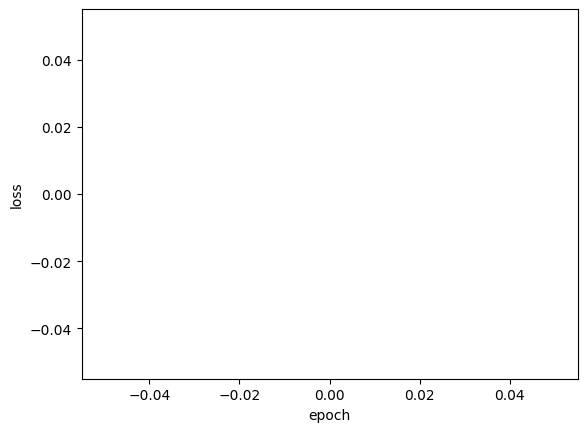


 ********************
Testing the model ...

f1 score is:  0.972352595349474

*********************
Evaluation test results ... 

True positive is:  7266
False negative is:  210
New positive is:  78366
New negative is:  1906250
False positive is:  215
True negative is:  7693

********************
Finish and the prediction output has been written in Result/prediction-cRE-whole-graph.pdf


In [44]:
hyper_parameters = set_default_hyper_parameters()

run_prediction(hyper_parameters, "Result/prediction-cRE-whole-graph.pdf")

epoch 1, loss 28.086288452148438 epoch 1, loss 26.911203384399414 epoch 1, loss 21.954513549804688 epoch 1, loss 21.533763885498047 epoch 1, loss 18.684795379638672 epoch 2, loss 17.98190689086914 epoch 2, loss 17.2799072265625 epoch 2, loss 15.495399475097656 epoch 2, loss 14.324470520019531 epoch 2, loss 13.781366348266602 epoch 3, loss 13.361822128295898 epoch 3, loss 12.652257919311523 epoch 3, loss 11.182487487792969 epoch 3, loss 10.797582626342773 epoch 3, loss 9.53971004486084 epoch 4, loss 9.688102722167969 epoch 4, loss 10.004800796508789 epoch 4, loss 9.103729248046875 epoch 4, loss 8.317834854125977 epoch 4, loss 8.346786499023438 epoch 5, loss 8.117074966430664 epoch 5, loss 7.611232757568359 epoch 5, loss 7.356451511383057 epoch 5, loss 7.297579288482666 epoch 5, loss 6.961786270141602 epoch 6, loss 7.129212379455566 epoch 6, loss 7.009449005126953 epoch 6, loss 6.213137149810791 epoch 6, loss 6.339641571044922 epoch 6, loss 6.056020736694336 epoch 7, loss 5.8672127723693

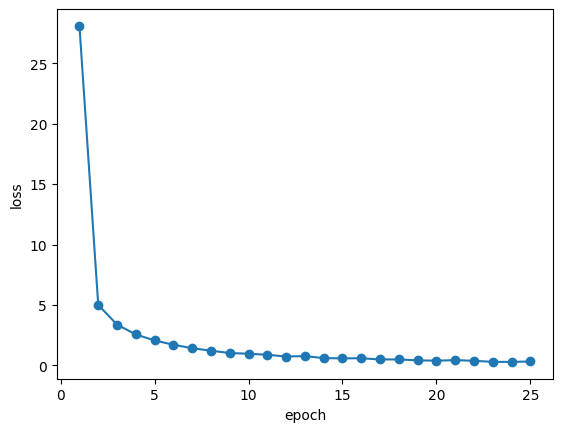

In [64]:
z = input().split()
x = [float(z[i]) for i in range(len(z)) if i % 160 == 3]
plot_losses(x)

NameError: ignored

# Just For Testing Different methods

In [ ]:
def set_test_hyper_parameters():

  default_hyper_parameters = {'portion_hidden_edges': PORTION_HIDDEN_EDGES, 'ratio_negative_to_positive': 3, 
                              'radius': RADIUS, 'number_of_sample_dataset': 100, 'random_size':  RANDOM_SIZE, 
                              'neighbor_size': NEIGHBOR_SIZE, 'ratio_test_size': RATIO_TEST_SIZE, 'feature_selected': FEATURE_LIST, 
                              'batch_size': BATCH_SIZE, 'number_feature_comb':  NUMBER_FEATURE_COMB, 'gcn_input_size': GCN_INPUT_SIZE, 
                              'gcn_hidden_size': GCN_HIDDEN_SIZE, 'gcn_output_size': GCN_OUTPUT_SIZE, 'number_of_epochs': 20, 
                              'backward_lim': BACKWARD_LIM, 'num_nodes_each_part_pred':  NUM_NODES_EACH_PART_PRED, 'list_feature_index': LIST_FEATURE_INDEX}
  return default_hyper_parameters

In [ ]:
class gnn_network(torch.nn.Module):

    def __init__(self, index_size, gcn_input_size, gcn_hidden_size, gcn_output_size, batch_size, sample_size, cre_dataset):

        super(gnn_network, self).__init__()

        self.conv1 = GCNConv(gcn_input_size, gcn_hidden_size)
        self.conv2 = GCNConv(gcn_hidden_size, gcn_output_size)


        # self.conv_embedings1 = nn.Conv2d(self.sample_size, 200, 5)
        # self.conv_embedings2 = nn.Conv2d(6, 16, 5)

        self.matrix = Variable(torch.randn(gcn_output_size, gcn_output_size).type(torch.FloatTensor), requires_grad=True)
        self.linear = torch.nn.Linear(1,2)

        self.bilinear = nn.Bilinear(20, 30, 40)

        self.transform1 = nn.Linear(index_size, gcn_input_size)
        self.transform2 = nn.Linear(768, gcn_input_size)

        self.sample_size = sample_size
        self.index_size = index_size      

    def forward(self, data):

        x, edge_index = data.x, data.edge_index
        attributes1 = x[:, :self.index_size].float()
        attributes2 = x[:, self.index_size:].float()

        x = self.transform1(attributes1)+self.transform2(attributes2)
        x = self.conv1(x.float(), edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        ypred = []
        for i in range(x.size(0) // self.sample_size):
            embedings = x[i * self.sample_size:(i+1) * self.sample_size, :]
            print(embedinds.shape)
            print(torch.matmul(embedings, self.matrix).shape)
            print(torch.matmul(torch.matmul(embedings, self.matrix), embedings.t()))
            ypred.append(self.linear(torch.matmul(torch.matmul(embedings, self.matrix), embedings.t()).unsqueeze(-1)).view(-1, 2))
        
        return torch.stack(ypred).view(-1,2)

In [ ]:
def train_gnn_model(gcn_input_size, gcn_hidden_size, gcn_output_size, batch_size, sample_size, cre_dataset, 
                    feature_inp, num_epochs, backward_lim, dataset_train):
  
  feature = torch.tensor(feature_inp)
  model = gnn_network(feature.size(0), gcn_input_size, gcn_hidden_size,gcn_output_size,  batch_size, sample_size, cre_dataset)
  criterion = torch.nn.CrossEntropyLoss(ignore_index =-1)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
  all_features_index = torch.cat([feature, torch.Tensor(list(range(11,779))).long()],dim=0)
  dataset_train_selected_att = [Data(x = torch.index_select(data.x, 1, all_features_index), edge_index = data.edge_index, y = data.y) for data in dataset_train]
  loader = DataLoader(dataset_train_selected_att, batch_size = batch_size, shuffle=True)

  for epoch in range(num_epochs):
    count = 0
    loss = 0
    for data in loader:
        pred_y = model(data)
        loss = loss + criterion(pred_y, data.y)
        # print("Pred y and data.y", pred_y, data.y)
        # input()
        count = count + 1
        if(count == backward_lim):
            loss.backward()
            optimizer.step()
            print('epoch {}, loss {}'.format(epoch, loss.item()))
            optimizer.zero_grad()
            loss = 0
            count = 0 
    if(loss != 0):
        loss.backward()
        optimizer.step()
        print('epoch {}, loss {}'.format(epoch, loss.item()))
        optimizer.zero_grad()
  return model

In [ ]:
print("Loading dataset ...\n")

cre_dataset = CreDataset(PATH_CRE_ATTRIBUTES, PATH_DNA, PATH_EDGE)

print("Dataset info: ", cre_dataset)
print("******************")


hyper_parameters = set_test_hyper_parameters()


cRE_edge_matrix_input = generate_positive_negative_matrix(hyper_parameters['portion_hidden_edges'], hyper_parameters['ratio_negative_to_positive'], 
                                                            cre_dataset)
generate_graph_pic(cRE_edge_matrix_input, PATH_FOLDER + "/Result/cRE-with zeros.pdf")

Loading dataset ...

Dataset info:  Number of nodes is: 9946
Number of edges is: 79389
Number of DNA of each cRE is: 768
Number of selected attributes of each cRE is: 11

******************


In [ ]:
dataset_train, dataset_test = generate_subgraphs(cre_dataset, cRE_edge_matrix_input, hyper_parameters['radius'], hyper_parameters['random_size'],
                    hyper_parameters['neighbor_size'], hyper_parameters['number_of_sample_dataset'], hyper_parameters['ratio_test_size'])

print("\n\n******************")
print('Training the model ...\n')

model_cRE_edge_predictor = train_gnn_model(hyper_parameters['gcn_input_size'], hyper_parameters['gcn_hidden_size'],
                                            hyper_parameters['gcn_output_size'], hyper_parameters['batch_size'],
                                            hyper_parameters['neighbor_size'] + hyper_parameters['random_size'], cre_dataset, 
                                            hyper_parameters['feature_selected'], hyper_parameters['number_of_epochs'],
                                            hyper_parameters['backward_lim'], dataset_train)
print("\n ********************")
print("Testing the model ...\n")

100%|██████████| 100/100 [00:09<00:00, 10.09it/s]




******************
Training the model ...

epoch 0, loss 44.232200622558594
epoch 1, loss 33.100101470947266
epoch 2, loss 32.05465316772461
epoch 3, loss 27.8249454498291
epoch 4, loss 23.526899337768555
epoch 5, loss 22.63251495361328
epoch 6, loss 19.5361385345459
epoch 7, loss 18.142560958862305
epoch 8, loss 17.29340171813965
epoch 9, loss 15.367584228515625
epoch 10, loss 14.158831596374512
epoch 11, loss 12.57180404663086
epoch 12, loss 11.539145469665527
epoch 13, loss 9.917947769165039
epoch 14, loss 9.592373847961426
epoch 15, loss 8.993619918823242
epoch 16, loss 8.498170852661133
epoch 17, loss 7.944671154022217
epoch 18, loss 7.446652889251709
epoch 19, loss 7.1165666580200195

 ********************
Testing the model ...



In [ ]:
key_list=['A','B','C','D','E','F','G','H','I','J','K']
key_inp = "".join(key_list) 
y_true, y_pred = test_model(hyper_parameters['feature_selected'], model_cRE_edge_predictor, hyper_parameters['batch_size'], key_inp, dataset_test)

print("\n*********************")
print("Evaluation test results ... \n")

evaluate_result(y_pred, y_true)

f1 score is:  0.7260273249986813

*********************
Evaluation test results ... 

True positive is:  543
False negative is:  181
New positive is:  59158
New negative is:  139598
False positive is:  153
True negative is:  367
